In [2]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine
from GTGP import GTGP


from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [4]:
df = pd.read_csv("../data/shuttle.dat",delimiter=',')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

seeds = [10086, 200,500,30506,30405,30420,10056,7059,40965,5398,869543,83491,823190,
         48392,2810,48392,3498210,483902,859032,12890,538920,86954,54309,6504,9840,
         219805,548,2981,432890,5438908,219094,5843902,60854,979,12890,2108,4093]
train_size = 0.7
dataset = 'shuttle'

In [5]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

# model

In [18]:
def fit_trees(tolerance = 0.001,max_nodes=1000):
    learning_rate=1
    max_depth=1
    bins=5
    lam=10

    gtgp = GTGP(learning_rate=learning_rate,max_depth=max_depth,bins=bins,lam=lam)

    total_size=10
    elite_size = 10
    epoch= 10
    gp_epoch= 3
    verbose = 1

    gtgp.fit_fixed_number(X_train,y_train,total_size=total_size,elite_size = elite_size,epoch=epoch,gp_epoch=gp_epoch,tolerance=tolerance,max_nodes=max_nodes,verbose=verbose)
    # gtgp.fit(X_train,y_train,total_size=total_size,elite_size = elite_size,epoch=epoch,gp_epoch=gp_epoch,tolerance=tolerance,verbose=verbose)

    # retrain_epoch= max(3000//sum([tree.numNode for tree in gtgp.stack]),1)
    retrain_epoch = 5

    alpha=0
    beta=1
    gammer=0

    verbose=1
    gtgp.lam = 10
    gtgp.retrain_estimators(X_test,y_test,retrain_epoch=retrain_epoch,alpha=alpha,beta=beta,gammer=gammer,verbose=verbose)

    return gtgp


test_sses = []
test_accs = []

tors = [0,1e-12,1e-4,1e-2]
# tors = [1e-2]
for t in tors:
    test_sse = []
    test_acc = []
    for i in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
        y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

        gtgp = fit_trees(tolerance=t,max_nodes=1000)
        num_trees,depth,num_nodes = gtgp.print_model()
        test_sse.append(gtgp.test_sse)
        test_acc.append(gtgp.test_acc)
    min_epoch = min([len(t) for t in test_acc])
    test_sses.append(test_sse)
    test_accs.append(test_acc)

30 150 1
60 294 2
90 444 3
120 610 4
150 764 5
180 918 6
210 1082 7
retrain  1 :
	train: 0.9934233213458791 0.6610660043192135 	test: 0.9925287356321839 0.6657926873329407
retrain  2 :
	train: 0.9958126016059904 0.7661751989627048 	test: 0.9951149425287357 0.7440399740247996
retrain  3 :
	train: 0.9965515542637569 0.8396830722021598 	test: 0.9956896551724138 0.7627527886432052
retrain  4 :
	train: 0.996723976550569 0.8540990189163177 	test: 0.9958620689655172 0.7618565543146333
retrain  5 :
	train: 0.9968963988373811 0.8560000454255338 	test: 0.9962068965517241 0.7622455409830623
----------------GTGP-------------
Number of Trees: 210
Average of depth: 1.7809523809523808
Number of nodes: 1082
30 150 1
60 306 2
90 436 3
120 574 4
150 720 5
180 884 6
210 1028 7
retrain  1 :
	train: 0.9969949258584166 0.781946964955128 	test: 0.9973563218390804 0.736571862103939
retrain  2 :
	train: 0.9985220946844672 0.839964142448369 	test: 0.998735632183908 0.7914899925926894
retrain  3 :
	train: 0.9988

In [19]:
[len(t) for t in test_sses]

[30, 30, 30, 30]

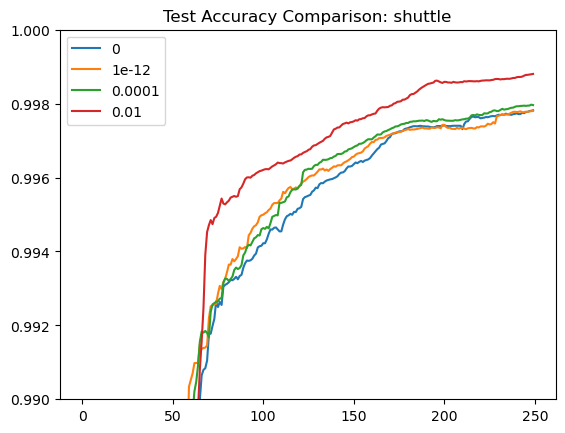

In [28]:
length = 250
test_acc_avgs = []
for t in test_accs:
    avg = []
    for i in range(length):
        avg.append(np.average([x[i] for x in t]))
    test_acc_avgs.append(avg)

for i in range(len(test_acc_avgs)):
    plt.plot(test_acc_avgs[i])
    # plt.plot(test_sses[i][:min_epoch])

# plt.yscale('log')
plt.title("Test Accuracy Comparison: "+dataset)
plt.ylim(0.99,1)
plt.legend(tors[:len(test_sses)])
plt.show()


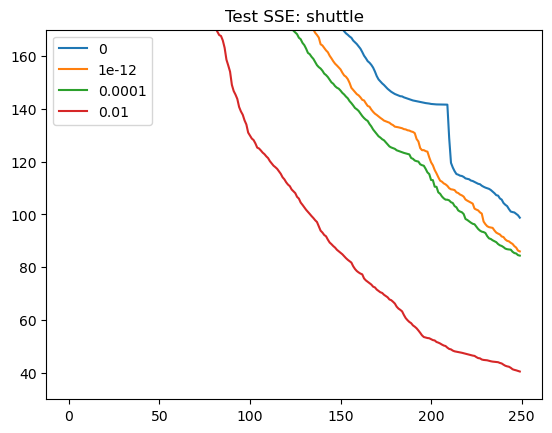

In [29]:
length = 250
test_sse_avg = []
for t in test_sses:
    avg = []
    for i in range(length):
        avg.append(np.average([x[i] for x in t]))
    test_sse_avg.append(avg)

for i in range(len(test_sse_avg)):
    plt.plot(test_sse_avg[i])
    # plt.plot(test_sses[i][:min_epoch])

# plt.yscale('log')
plt.title("Test SSE: "+dataset)
plt.ylim(30,170)
plt.legend(tors[:len(test_sses)])
plt.show()
